In [1]:
import os
from os.path import join as pjoin
from scipy.io import wavfile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
tf.config.list_physical_devices('GPU')

original_data_dir = pjoin(os.getcwd(),"..\\AudioFiles","wavs")
compressed_data_dir = pjoin(os.getcwd(),"..\\AudioFiles","medio")
original_fname = pjoin(original_data_dir, '55_tdcast.wav')
compressed_fname = pjoin(compressed_data_dir, '55_tdcast.wav')

In [2]:
samplerate, original_data = wavfile.read(original_fname)
print(f"number of channels = {original_data.shape[1]}")

length = original_data.shape[0] / samplerate
print(f"length = {length}s")

samplerate, compressed_data = wavfile.read(compressed_fname)

number of channels = 2
length = 1379.4220408163264s


<ipython-input-2-9493e236311b>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, compressed_data = wavfile.read(compressed_fname)


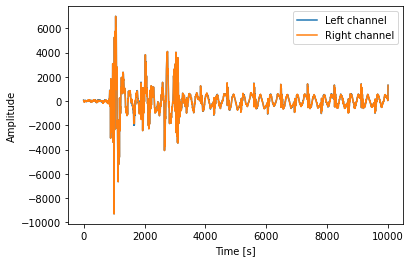

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(original_data[10000:20000, 0], label="Left channel")
plt.plot(original_data[10000:20000, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [4]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)

In [5]:
a = np.array([1,2,3,4,5,6,7,2])
getSamplesFromFile(a, 5)

array([[[1],
        [2],
        [3],
        [4],
        [5]]])

In [6]:
max_data = np.max(original_data[:, 0].astype(np.float32))

In [7]:
samplesize = 50
data = original_data[:, 0].astype(np.float32)
data = data/np.max(data)
y = getSamplesFromFile(original_data, samplesize)
X = getSamplesFromFile(compressed_data, samplesize)

In [8]:
val_start = int(len(X)*.9)
X_train,X_valid = X[:val_start],X[val_start:]
Y_train,Y_valid = y[:val_start],y[val_start:]


In [12]:
#
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    
    keras.layers.LSTM(samplesize, return_sequences=False,input_shape=[None,  1])
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
Total params: 10,400
Trainable params: 10,400
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss="mse", optimizer="adam")

In [14]:
print(X_train.shape, X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(2189970, 50, 1) (243330, 50, 1)
(2189970, 50, 1) (243330, 50, 1)


In [17]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=1024,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683212.0000 - val_loss: 22273012.0000
Epoch 2/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683216.0000 - val_loss: 22272894.0000
Epoch 3/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683108.0000 - val_loss: 22272976.0000
Epoch 4/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683088.0000 - val_loss: 22272856.0000
Epoch 5/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683080.0000 - val_loss: 22272892.0000
Epoch 6/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683074.0000 - val_loss: 22272782.0000
Epoch 7/10
2139/2139 [==============================] - 24s 11ms/step - loss: 20683166.0000 - val_loss: 22272894.0000
Epoch 8/10
2139/2139 [==============================] - 23s 11ms/step - loss: 20683134.0000 - val_loss: 22272856.0000
Epoch 9/10
2139/2139 [==============================] - 

In [18]:
model.save('./checkpoints/lstmodel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./checkpoints/lstmodel\assets


In [23]:
import time
a = time.perf_counter()
predicted = model.predict(X_valid[:10000])
b = time.perf_counter()

In [24]:
audio_validacao = X_valid.reshape(-1)
print(f"Velocidade de previsão: {(100/samplerate)/(b-a)}")

Velocidade de previsão: 0.005746605358386659


In [26]:
predicted.shape

(10000, 50)

In [32]:
import simpleaudio as sa
def play_seq(seq, volume):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, samplerate)
    return play_obj

In [33]:
x = play_seq(predicted, .1) #Predito

In [34]:
def save_seq(name,seq, volume, samplerate):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    wavfile.write(name,samplerate*2,audio)

In [35]:
save_seq("predicted.wav", predicted, .5, samplerate)

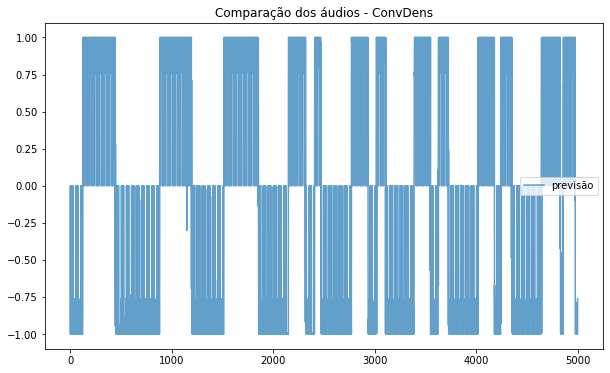

In [39]:
base = 8000
amount = 100
plt.figure(figsize=(10,6))
plt.title("Comparação dos áudios - ConvDens")
plt.plot(predicted[base:base+amount].reshape(-1), label="previsão", alpha=.7)
#plt.plot(Y_valid[base:base+amount].reshape(-1), label="original", alpha=.7)
plt.legend()
plt.savefig("convconv-prevorig.png")
plt.show()